In [163]:
import json
import pandas as pd
import random
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors
import numpy as np
from scipy.spatial.distance import cosine
import fasttext
from huggingface_hub import hf_hub_download
import gensim.downloader
import matplotlib.pyplot as plt


In [2]:
with open('train_rand_split.jsonl', 'r') as file:
    data = [json.loads(line) for line in file]

In [3]:
data

[{'answerKey': 'A',
  'id': '075e483d21c29a511267ef62bedc0461',
  'question': {'question_concept': 'punishing',
   'choices': [{'label': 'A', 'text': 'ignore'},
    {'label': 'B', 'text': 'enforce'},
    {'label': 'C', 'text': 'authoritarian'},
    {'label': 'D', 'text': 'yell at'},
    {'label': 'E', 'text': 'avoid'}],
   'stem': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?'}},
 {'answerKey': 'B',
  'id': '61fe6e879ff18686d7552425a36344c8',
  'question': {'question_concept': 'people',
   'choices': [{'label': 'A', 'text': 'race track'},
    {'label': 'B', 'text': 'populated areas'},
    {'label': 'C', 'text': 'the desert'},
    {'label': 'D', 'text': 'apartment'},
    {'label': 'E', 'text': 'roadblock'}],
   'stem': 'Sammy wanted to go to where the people were.  Where might he go?'}},
 {'answerKey': 'A',
  'id': '4c1cb0e95b99f72d55c068ba0255c54d',
  'question': {'question_concept': 'choker',
   'choices': [

In [4]:
df = pd.DataFrame(data)

In [5]:
df

,answerKey,id,question
0,A,075e483d21c29a511267ef62bedc0461,"{'question_concept': 'punishing', 'choices': [..."
1,B,61fe6e879ff18686d7552425a36344c8,"{'question_concept': 'people', 'choices': [{'l..."
2,A,4c1cb0e95b99f72d55c068ba0255c54d,"{'question_concept': 'choker', 'choices': [{'l..."
3,D,02e821a3e53cb320790950aab4489e85,"{'question_concept': 'highway', 'choices': [{'..."
4,C,23505889b94e880c3e89cff4ba119860,"{'question_concept': 'fox', 'choices': [{'labe..."
...,...,...,...
9736,E,f1b2a30a1facff543e055231c5f90dd0,"{'question_concept': 'going public', 'choices'..."
9737,D,a63b4d0c0b34d6e5f5ce7b2c2c08b825,"{'question_concept': 'chair', 'choices': [{'la..."
9738,A,22d0eea15e10be56024fd00bb0e4f72f,"{'question_concept': 'jeans', 'choices': [{'la..."
9739,A,7c55160a4630de9690eb328b57a18dc2,"{'question_concept': 'well', 'choices': [{'lab..."


In [6]:
# Extract relevant features from the question dictionary
df['stem'] = df['question'].apply(lambda x: x['stem'])
df['choices'] = df['question'].apply(lambda x: {choice['label']: choice['text'] for choice in x['choices']})

df.drop('question', axis=1, inplace=True)

df = df[['id', 'stem', 'choices', 'answerKey']]



In [7]:
df

,id,stem,choices,answerKey
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,"{'A': 'ignore', 'B': 'enforce', 'C': 'authorit...",A
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,"{'A': 'race track', 'B': 'populated areas', 'C...",B
2,4c1cb0e95b99f72d55c068ba0255c54d,To locate a choker not located in a jewelry bo...,"{'A': 'jewelry store', 'B': 'neck', 'C': 'jewl...",A
3,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,"{'A': 'united states', 'B': 'mexico', 'C': 'co...",D
4,23505889b94e880c3e89cff4ba119860,"The fox walked from the city into the forest, ...","{'A': 'pretty flowers.', 'B': 'hen house', 'C'...",C
...,...,...,...,...
9736,f1b2a30a1facff543e055231c5f90dd0,What would someone need to do if he or she wan...,"{'A': 'consequences', 'B': 'being ridiculed', ...",E
9737,a63b4d0c0b34d6e5f5ce7b2c2c08b825,Where might you find a chair at an office?,"{'A': 'stadium', 'B': 'kitchen', 'C': 'porch',...",D
9738,22d0eea15e10be56024fd00bb0e4f72f,Where would you buy jeans in a place with a la...,"{'A': 'shopping mall', 'B': 'laundromat', 'C':...",A
9739,7c55160a4630de9690eb328b57a18dc2,John fell down the well. he couldn't believe ...,"{'A': 'fairytale', 'B': 'farm yard', 'C': 'far...",A


In [8]:
df.isna().sum()

id           0
stem         0
choices      0
answerKey    0
dtype: int64

In [9]:
df["answerKey"].unique()

array(['A', 'B', 'D', 'C', 'E'], dtype=object)

# Use Baseline Model => just Random Guessing

In [10]:
answer_choices = df["choices"]

random_predictions = [random.choice(list(choices.keys())) for choices in answer_choices]

In [11]:
random_predictions

['D',
 'D',
 'C',
 'C',
 'A',
 'E',
 'B',
 'B',
 'B',
 'C',
 'C',
 'E',
 'C',
 'B',
 'E',
 'A',
 'E',
 'C',
 'E',
 'C',
 'D',
 'A',
 'B',
 'B',
 'E',
 'E',
 'D',
 'A',
 'C',
 'E',
 'B',
 'D',
 'E',
 'C',
 'B',
 'A',
 'A',
 'B',
 'E',
 'B',
 'C',
 'A',
 'B',
 'B',
 'C',
 'B',
 'D',
 'A',
 'D',
 'E',
 'D',
 'B',
 'D',
 'A',
 'B',
 'B',
 'D',
 'E',
 'B',
 'C',
 'C',
 'E',
 'D',
 'A',
 'C',
 'C',
 'B',
 'B',
 'B',
 'C',
 'C',
 'B',
 'A',
 'D',
 'C',
 'D',
 'A',
 'B',
 'E',
 'B',
 'A',
 'A',
 'D',
 'E',
 'C',
 'B',
 'B',
 'A',
 'E',
 'C',
 'E',
 'A',
 'A',
 'C',
 'D',
 'A',
 'E',
 'D',
 'C',
 'C',
 'C',
 'A',
 'E',
 'E',
 'E',
 'E',
 'A',
 'A',
 'D',
 'D',
 'A',
 'A',
 'D',
 'A',
 'E',
 'A',
 'D',
 'B',
 'C',
 'C',
 'E',
 'B',
 'C',
 'C',
 'A',
 'E',
 'E',
 'A',
 'B',
 'B',
 'E',
 'D',
 'D',
 'E',
 'A',
 'D',
 'A',
 'C',
 'C',
 'E',
 'B',
 'B',
 'C',
 'E',
 'A',
 'B',
 'D',
 'B',
 'A',
 'D',
 'C',
 'D',
 'E',
 'D',
 'D',
 'E',
 'C',
 'D',
 'A',
 'B',
 'C',
 'B',
 'A',
 'C',
 'B',
 'A',
 'D'

# Compute the accuracy for this model  

In [12]:
correct_answers = df["answerKey"]
accuracy_of_the_baseline_model = accuracy_score(correct_answers, random_predictions)
print("Random Guessing Baseline Accuracy:", accuracy_of_the_baseline_model)

Random Guessing Baseline Accuracy: 0.20624165896725183


# Preprocessing-Phase 

In [13]:
df['tokens'] = df['stem'].apply(word_tokenize)

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\668070078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['stem'].apply(word_tokenize)


In [14]:
df["stem"] = df['tokens']

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\959468976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stem"] = df['tokens']


In [15]:
# Convert all words to lowercase 
df["stem"] = df["stem"].apply(lambda x: [word.lower() for word in x])

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\194360467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stem"] = df["stem"].apply(lambda x: [word.lower() for word in x])


In [16]:
df["stem"]

0       [the, sanctions, against, the, school, were, a...
1       [sammy, wanted, to, go, to, where, the, people...
2       [to, locate, a, choker, not, located, in, a, j...
3       [google, maps, and, other, highway, and, stree...
4       [the, fox, walked, from, the, city, into, the,...
                              ...                        
9736    [what, would, someone, need, to, do, if, he, o...
9737    [where, might, you, find, a, chair, at, an, of...
9738    [where, would, you, buy, jeans, in, a, place, ...
9739    [john, fell, down, the, well, ., he, could, n'...
9740    [i, forgot, to, pay, the, electricity, bill, ,...
Name: stem, Length: 9741, dtype: object

In [17]:
#Remove Stop Words

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [20]:
# Remove stop words from the tokens
df["stem"] = df["stem"].apply(lambda x: [word for word in x if word not in stop_words])

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\1215673481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stem"] = df["stem"].apply(lambda x: [word for word in x if word not in stop_words])


In [21]:
# Remove punctuation from the tokens
df["stem"] = df["stem"].apply(lambda x: [word for word in x if word not in string.punctuation])

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\2979354873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stem"] = df["stem"].apply(lambda x: [word for word in x if word not in string.punctuation])


In [22]:
df["stem"][0]

['sanctions',
 'school',
 'punishing',
 'blow',
 'seemed',
 'efforts',
 'school',
 'made',
 'change']

In [39]:
def tokenize_and_lowercase_answers(choices):
    tokenized_choices = {}
    for key, value in choices.items(): #as a tupel
        tokens = word_tokenize(value)  # Tokenize the answer choice
        tokens = [token.lower() for token in tokens]  # Convert tokens to lowercase
        tokenized_choices[key] = tokens
    return tokenized_choices

In [40]:
df["tokenized_choices"] = df["choices"].apply(tokenize_and_lowercase_answers)

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\1888519524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokenized_choices"] = df["choices"].apply(tokenize_and_lowercase_answers)


In [41]:
df["choices"] = df["tokenized_choices"]

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\3135468177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["choices"] = df["tokenized_choices"]


# Load  word2vec model

In [24]:
path = 'C:\\Users\\IMOE001\\Desktop\\GoogleNews-vectors-negative300.bin'

In [26]:
word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [27]:
word2vec_model

In [28]:
# Test some words
words_to_test = ['king', 'queen', 'man', 'woman', 'car', 'house' , 'roaa']

# Check if each word is present in the vocabulary
for word in words_to_test:
    if word in word2vec_model:
        print(f"Vector representation of '{word}': {word2vec_model[word]}")
    else:
        print(f"'{word}' is not present in the vocabulary.")


Vector representation of 'king': [ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582

# Word2vec

In [29]:
df["stem"][0]

['sanctions',
 'school',
 'punishing',
 'blow',
 'seemed',
 'efforts',
 'school',
 'made',
 'change']

In [30]:
#get the question as a vector 

In [207]:
def number_of_words_without_embedding(the_column,the_column2 ,  model):
    count = 0
    for wordlist in the_column:
        for word in wordlist:
            if word not in model:
                count += 1
                
    for row in the_column2 : 
        for wordlist in row.values() : 
            for word in wordlist:
                if word not in model:
                    count += 1
    return count

In [208]:
df["choices"][0].values()

dict_values([['ignore'], ['enforce'], ['authoritarian'], ['yell', 'at'], ['avoid']])

In [209]:
number_of_words_without_embedding_using_word2vec = number_of_words_without_embedding(df["stem"] , df["choices"] ,  word2vec_model )

In [210]:
number_of_words_without_embedding_using_word2vec

3511

In [199]:
df

,id,stem,choices,answerKey,answer_vectors_use_word2vec,question_vectors_use_word2vec,question_vector_use_fasttext,answer_vectors_use_fastext,question_vector_use_fasttext_2,answer_vectors_use_fastext_2,question_vector_use_glove,answer_vectors_use_glove
0,075e483d21c29a511267ef62bedc0461,"[sanctions, school, punishing, blow, seemed, e...","{'A': ['ignore'], 'B': ['enforce'], 'C': ['aut...",A,"{'A': [0.18847656, -0.07080078, 0.08984375, 0....","[0.0675727, 0.14439562, 0.091145836, 0.1265547...","[-0.0016222232, -0.0027555574, -0.0033444455, ...","{'A': [0.0564, 0.071, -0.0622, 0.0584, 0.0654,...","[0.013254745, 0.02077, 0.014991189, 0.01712364...","{'A': [0.073165, 0.0066673, -0.04286, 0.01285,...","[0.08596054, 0.007919003, -0.11098434, -0.2412...","{'A': [0.20537, 0.16994, -0.1674, 0.26461, 0.0..."
1,61fe6e879ff18686d7552425a36344c8,"[sammy, wanted, go, people, might, go]","{'A': ['race', 'track'], 'B': ['populated', 'a...",B,"{'A': [0.021240234, 0.05029297, 0.0513916, -0....","[0.0629069, 0.062805176, 0.043721516, 0.192057...","[-0.020499999, -0.019833332, -0.033266667, -0....","{'A': [0.04725, 0.061300002, 0.076249994, 0.11...","[-0.0005778006, 0.029545337, -0.016860284, 0.0...","{'A': [0.0326345, -0.059024997, 0.028618496, 0...","[-0.07433239, 0.07619534, -0.14286767, 0.12231...","{'A': [0.18181151, 0.0331005, -0.023118, 0.108..."
2,4c1cb0e95b99f72d55c068ba0255c54d,"[locate, choker, located, jewelry, box, boutiq...","{'A': ['jewelry', 'store'], 'B': ['neck'], 'C'...",A,"{'A': [-0.009765625, 0.07159424, -0.12402344, ...","[-0.057003975, -0.030448914, -0.03807068, 0.10...","[0.055412505, 0.025162507, -0.02265, -0.033637...","{'A': [0.1273, -0.06465, -0.1241, -0.14410001,...","[-0.00080324826, -0.023875248, -0.02409507, 0....","{'A': [-0.0843835, -0.0561015, -0.0729495, -0....","[-0.14180876, 0.4268127, -0.31200036, 0.063168...","{'A': [-0.19757998, 0.36833, -0.508785, -0.130..."
3,02e821a3e53cb320790950aab4489e85,"[google, maps, highway, street, gps, services,...","{'A': ['united', 'states'], 'B': ['mexico'], '...",D,"{'A': [0.061828613, 0.0009765625, 0.018737793,...","[0.10030256, -0.10193743, 0.068481445, 0.15154...","[-0.021357145, 0.08934285, -0.053799998, 0.028...","{'A': [0.0651, -0.06855, 0.0818, -0.04975, 0.0...","[0.04678386, -0.028505284, 0.004389914, 0.0212...","{'A': [0.0179755, -0.014377501, -0.0058429996,...","[-0.46263832, -0.36831856, 0.040793713, 0.0141...","{'A': [0.055304, -0.21757, 0.18440801, -0.1360..."
4,23505889b94e880c3e89cff4ba119860,"[fox, walked, city, forest, looking]","{'A': ['pretty', 'flowers', '.'], 'B': ['hen',...",C,"{'A': [0.07220459, 0.10046387, -0.011230469, 0...","[0.08167724, 0.10446777, 0.012615967, 0.022607...","[0.03813999, 0.06638, -0.056439996, -0.0180000...","{'A': [-0.007333333, -0.019, -0.047999997, -0....","[0.015745, -0.033993863, 0.0077821985, 0.03021...","{'A': [0.0209789, -0.0031158996, 0.034169067, ...","[-0.256418, -0.026419401, -0.045236997, -0.003...","{'A': [-0.36503997, -0.029608332, -0.13107766,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
9736,f1b2a30a1facff543e055231c5f90dd0,"[would, someone, need, wanted, going, public]","{'A': ['consequences'], 'B': ['being', 'ridicu...",E,"{'A': [0.118652344, -0.05859375, 0.13574219, 0...","[0.10651652, 0.08495077, 0.06915283, 0.0854899...","[-0.015266667, -0.04525, -0.026133334, -0.0321...","{'A': [0.0481, -0.0852, -0.0191, 0.004, 0.1879...","[0.009025407, 0.021891601, 0.00668415, 0.01024...","{'A': [0.0024473, -0.020313, -0.0098046, 0.035...","[-0.2629423, 0.029498165, -0.23902349, 0.00904...","{'A': [0.27946, 0.12613, 0.4375, -0.14033, -0...."
9737,a63b4d0c0b34d6e5f5ce7b2c2c08b825,"[might, find, chair, office]","{'A': ['stadium'], 'B': ['kitchen'], 'C': ['po...",D,"{'A': [0.08984375, 0.15917969, 0.45703125, -0....","[0.07040405, -0.11004639, -0.034179688, 0.0818...","[-0.044074994, 0.0071, -0.05935, 0.056274995, ...","{'A': [-0.008, 0.2166, 0.0851, 0.0373, 0.0147,...","[-0.01772575, -0.019174, 0.01414195, -0.007261.

In [47]:
def average_question_words_vectors(words, model):
    word_vectors = [] 
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    if word_vectors:
        return  np.mean(word_vectors, axis=0)
    else:
        return  np.zeros(model.vector_size)    # Return zero vector if no words found in the model

In [94]:
df["question_vector_use_word2vec"] = df["stem"].apply(lambda x: average_question_words_vectors(x, word2vec_model))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\3454752098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["question_vector_use_word2vec"] = df["stem"].apply(lambda x: average_question_words_vectors(x, word2vec_model))


In [148]:
#here we represant each question with vector 

In [49]:
df["question_vector"]

0       [0.0675727, 0.14439562, 0.091145836, 0.1265547...
1       [0.0629069, 0.062805176, 0.043721516, 0.192057...
2       [-0.057003975, -0.030448914, -0.03807068, 0.10...
3       [0.10030256, -0.10193743, 0.068481445, 0.15154...
4       [0.08167724, 0.10446777, 0.012615967, 0.022607...
                              ...                        
9736    [0.10651652, 0.08495077, 0.06915283, 0.0854899...
9737    [0.07040405, -0.11004639, -0.034179688, 0.0818...
9738    [0.0049743652, 0.06970215, -0.02508545, 0.1381...
9739    [-0.04144965, 0.088765465, -0.04129198, 0.0977...
9740    [0.0335083, 0.12621307, 0.001876831, -0.001770...
Name: question_vector, Length: 9741, dtype: object

In [50]:
df["choices"][0]

{'A': ['ignore'],
 'B': ['enforce'],
 'C': ['authoritarian'],
 'D': ['yell', 'at'],
 'E': ['avoid']}

In [51]:
def get_average_answer_vectors(choices, model):
    average_vectors = {}
    for key, tokens in choices.items():
        word_vectors = []
        for token in tokens:
            if token in model:
                word_vectors.append(model[token])
        if word_vectors:
            average_vector = np.mean(word_vectors, axis=0)
        else:
            average_vector = np.zeros(model.vector_size)
        average_vectors[key] = average_vector
    return average_vectors

In [52]:
df["average_answer_vectors"] = df["tokenized_choices"].apply(lambda x: get_average_answer_vectors(x, word2vec_model))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\2591815359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["average_answer_vectors"] = df["tokenized_choices"].apply(lambda x: get_average_answer_vectors(x, word2vec_model))


In [ ]:
# A : not real =>make them as one vector 

In [53]:
df

,id,stem,choices,answerKey,tokens,question_vector,tokenized_choices,average_answer_vectors
0,075e483d21c29a511267ef62bedc0461,"[sanctions, school, punishing, blow, seemed, e...","{'A': ['ignore'], 'B': ['enforce'], 'C': ['aut...",A,"[The, sanctions, against, the, school, were, a...","[0.0675727, 0.14439562, 0.091145836, 0.1265547...","{'A': ['ignore'], 'B': ['enforce'], 'C': ['aut...","{'A': [0.18847656, -0.07080078, 0.08984375, 0...."
1,61fe6e879ff18686d7552425a36344c8,"[sammy, wanted, go, people, might, go]","{'A': ['race', 'track'], 'B': ['populated', 'a...",B,"[Sammy, wanted, to, go, to, where, the, people...","[0.0629069, 0.062805176, 0.043721516, 0.192057...","{'A': ['race', 'track'], 'B': ['populated', 'a...","{'A': [0.021240234, 0.05029297, 0.0513916, -0...."
2,4c1cb0e95b99f72d55c068ba0255c54d,"[locate, choker, located, jewelry, box, boutiq...","{'A': ['jewelry', 'store'], 'B': ['neck'], 'C'...",A,"[To, locate, a, choker, not, located, in, a, j...","[-0.057003975, -0.030448914, -0.03807068, 0.10...","{'A': ['jewelry', 'store'], 'B': ['neck'], 'C'...","{'A': [-0.009765625, 0.07159424, -0.12402344, ..."
3,02e821a3e53cb320790950aab4489e85,"[google, maps, highway, street, gps, services,...","{'A': ['united', 'states'], 'B': ['mexico'], '...",D,"[Google, Maps, and, other, highway, and, stree...","[0.10030256, -0.10193743, 0.068481445, 0.15154...","{'A': ['united', 'states'], 'B': ['mexico'], '...","{'A': [0.061828613, 0.0009765625, 0.018737793,..."
4,23505889b94e880c3e89cff4ba119860,"[fox, walked, city, forest, looking]","{'A': ['pretty', 'flowers', '.'], 'B': ['hen',...",C,"[The, fox, walked, from, the, city, into, the,...","[0.08167724, 0.10446777, 0.012615967, 0.022607...","{'A': ['pretty', 'flowers', '.'], 'B': ['hen',...","{'A': [0.07220459, 0.10046387, -0.011230469, 0..."
...,...,...,...,...,...,...,...,...
9736,f1b2a30a1facff543e055231c5f90dd0,"[would, someone, need, wanted, going, public]","{'A': ['consequences'], 'B': ['being', 'ridicu...",E,"[What, would, someone, need, to, do, if, he, o...","[0.10651652, 0.08495077, 0.06915283, 0.0854899...","{'A': ['consequences'], 'B': ['being', 'ridicu...","{'A': [0.118652344, -0.05859375, 0.13574219, 0..."
9737,a63b4d0c0b34d6e5f5ce7b2c2c08b825,"[might, find, chair, office]","{'A': ['stadium'], 'B': ['kitchen'], 'C': ['po...",D,"[Where, might, you, find, a, chair, at, an, of...","[0.07040405, -0.11004639, -0.034179688, 0.0818...","{'A': ['stadium'], 'B': ['kitchen'], 'C': ['po...","{'A': [0.08984375, 0.15917969, 0.45703125, -0...."
9738,22d0eea15e10be56024fd00bb0e4f72f,"[would, buy, jeans, place, large, number, indo...","{'A': ['shopping', 'mall'], 'B': ['laundromat'...",A,"[Where, would, you, buy, jeans, in, a, place, ...","[0.0049743652, 0.06970215, -0.02508545, 0.1381...","{'A': ['shopping', 'mall'], 'B': ['laundromat'...","{'A': [0.18408203, 0.19262695, -0.12524414, 0...."
9739,7c55160a4630de9690eb328b57a18dc2,"[john, fell, well, could, n't, believe, found,...","{'A': ['fairytale'], 'B': ['farm', 'yard'], 'C...",A,"[John, fell, down, the, well, ., he, could, n'...","[-0.04144965, 0.088765465, -0.04129198, 0.0977...","{'A': ['fairytale'], 'B': ['farm', 'yard'], 'C...","{'A': [0.23046875, -0.13476562, -0.13476562, -..."


# Make prediction use Word2vec

In [54]:
def cosine_similarity(vector1, vector2):
    return 1 - cosine(vector1, vector2)

In [55]:
#here we want the vector that give me the maxmum cosine similarity with question vector
def get_predicted_answer(question_vector, answer_vectors):
    max_similarity = -1
    max_label = None
    for label, answer_vector in answer_vectors.items():
        similarity = cosine_similarity(question_vector, answer_vector)
        if similarity > max_similarity:
            max_similarity = similarity
            max_label = label
    return max_label

In [56]:
predicted_answers_use_word2vec = df.apply(lambda row: get_predicted_answer(row["question_vector"], row["average_answer_vectors"]), axis=1)

C:\Users\IMOE001\anaconda3\lib\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [144]:
accuracy_of_word2vec = accuracy_score(df["answerKey"], predicted_answers_use_word2vec)
print("Accuracy:", accuracy_of_word2vec)

Accuracy: 0.29668411867364747


In [58]:
df.rename(columns={'average_answer_vectors': 'answer_vectors'}, inplace=True)

C:\Users\IMOE001\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [59]:
df

,id,stem,choices,answerKey,tokens,question_vector,tokenized_choices,answer_vectors
0,075e483d21c29a511267ef62bedc0461,"[sanctions, school, punishing, blow, seemed, e...","{'A': ['ignore'], 'B': ['enforce'], 'C': ['aut...",A,"[The, sanctions, against, the, school, were, a...","[0.0675727, 0.14439562, 0.091145836, 0.1265547...","{'A': ['ignore'], 'B': ['enforce'], 'C': ['aut...","{'A': [0.18847656, -0.07080078, 0.08984375, 0...."
1,61fe6e879ff18686d7552425a36344c8,"[sammy, wanted, go, people, might, go]","{'A': ['race', 'track'], 'B': ['populated', 'a...",B,"[Sammy, wanted, to, go, to, where, the, people...","[0.0629069, 0.062805176, 0.043721516, 0.192057...","{'A': ['race', 'track'], 'B': ['populated', 'a...","{'A': [0.021240234, 0.05029297, 0.0513916, -0...."
2,4c1cb0e95b99f72d55c068ba0255c54d,"[locate, choker, located, jewelry, box, boutiq...","{'A': ['jewelry', 'store'], 'B': ['neck'], 'C'...",A,"[To, locate, a, choker, not, located, in, a, j...","[-0.057003975, -0.030448914, -0.03807068, 0.10...","{'A': ['jewelry', 'store'], 'B': ['neck'], 'C'...","{'A': [-0.009765625, 0.07159424, -0.12402344, ..."
3,02e821a3e53cb320790950aab4489e85,"[google, maps, highway, street, gps, services,...","{'A': ['united', 'states'], 'B': ['mexico'], '...",D,"[Google, Maps, and, other, highway, and, stree...","[0.10030256, -0.10193743, 0.068481445, 0.15154...","{'A': ['united', 'states'], 'B': ['mexico'], '...","{'A': [0.061828613, 0.0009765625, 0.018737793,..."
4,23505889b94e880c3e89cff4ba119860,"[fox, walked, city, forest, looking]","{'A': ['pretty', 'flowers', '.'], 'B': ['hen',...",C,"[The, fox, walked, from, the, city, into, the,...","[0.08167724, 0.10446777, 0.012615967, 0.022607...","{'A': ['pretty', 'flowers', '.'], 'B': ['hen',...","{'A': [0.07220459, 0.10046387, -0.011230469, 0..."
...,...,...,...,...,...,...,...,...
9736,f1b2a30a1facff543e055231c5f90dd0,"[would, someone, need, wanted, going, public]","{'A': ['consequences'], 'B': ['being', 'ridicu...",E,"[What, would, someone, need, to, do, if, he, o...","[0.10651652, 0.08495077, 0.06915283, 0.0854899...","{'A': ['consequences'], 'B': ['being', 'ridicu...","{'A': [0.118652344, -0.05859375, 0.13574219, 0..."
9737,a63b4d0c0b34d6e5f5ce7b2c2c08b825,"[might, find, chair, office]","{'A': ['stadium'], 'B': ['kitchen'], 'C': ['po...",D,"[Where, might, you, find, a, chair, at, an, of...","[0.07040405, -0.11004639, -0.034179688, 0.0818...","{'A': ['stadium'], 'B': ['kitchen'], 'C': ['po...","{'A': [0.08984375, 0.15917969, 0.45703125, -0...."
9738,22d0eea15e10be56024fd00bb0e4f72f,"[would, buy, jeans, place, large, number, indo...","{'A': ['shopping', 'mall'], 'B': ['laundromat'...",A,"[Where, would, you, buy, jeans, in, a, place, ...","[0.0049743652, 0.06970215, -0.02508545, 0.1381...","{'A': ['shopping', 'mall'], 'B': ['laundromat'...","{'A': [0.18408203, 0.19262695, -0.12524414, 0...."
9739,7c55160a4630de9690eb328b57a18dc2,"[john, fell, well, could, n't, believe, found,...","{'A': ['fairytale'], 'B': ['farm', 'yard'], 'C...",A,"[John, fell, down, the, well, ., he, could, n'...","[-0.04144965, 0.088765465, -0.04129198, 0.0977...","{'A': ['fairytale'], 'B': ['farm', 'yard'], 'C...","{'A': [0.23046875, -0.13476562, -0.13476562, -..."


# Make Prediction use fasttext 

In [120]:
# Load the FastText model
fasttext_model_path = 'C:\\Users\\IMOE001\\Desktop\\wiki-news-300d-1M.vec'

In [122]:
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path)

In [213]:
number_of_words_w1ithout_embedding_using_fasttext = number_of_words_without_embedding(df["stem"] ,df["choices"], fasttext_model )

In [214]:
number_of_words_without_embedding_using_fasttext

843

In [126]:
df.rename(columns={'answer_vectors': 'answer_vectors_use_word2vec'}, inplace=True)

C:\Users\IMOE001\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [128]:
df.rename(columns={'question_vector_use_word2vec': 'question_vectors_use_word2vec'}, inplace=True)

C:\Users\IMOE001\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [130]:
df.drop(columns=['question_vector'], inplace=True)

C:\Users\IMOE001\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [137]:
df.drop(columns=['tokens', 'tokenized_choices'], inplace=True)

C:\Users\IMOE001\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [139]:
df["question_vector_use_fasttext"] = df["stem"].apply(lambda x: average_question_words_vectors(x, fasttext_model))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\2409255199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["question_vector_use_fasttext"] = df["stem"].apply(lambda x: average_question_words_vectors(x, fasttext_model))


In [141]:
df["answer_vectors_use_fastext"] = df["choices"].apply(lambda x: get_average_answer_vectors(x, fasttext_model))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\1410455318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["answer_vectors_use_fastext"] = df["choices"].apply(lambda x: get_average_answer_vectors(x, fasttext_model))


# Make Prediction use fasttex

In [143]:
predicted_answers_use_fasttex = df.apply(lambda row: get_predicted_answer(row["question_vector_use_fasttext"], row["answer_vectors_use_fastext"]), axis=1)

C:\Users\IMOE001\anaconda3\lib\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [146]:
accuracy_of_fastext = accuracy_score(df["answerKey"], predicted_answers_use_fasttex)
print("Accuracy:", accuracy_of_fastext)

Accuracy: 0.25100092392978135


In [149]:
#glove_model = gensim.downloader.load('glove-wiki-gigaword-300')
fasttext_model_2 = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [150]:
fasttext_model_2

In [151]:
df["question_vector_use_fasttext_2"] = df["stem"].apply(lambda x: average_question_words_vectors(x, fasttext_model_2))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\3786806535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["question_vector_use_fasttext_2"] = df["stem"].apply(lambda x: average_question_words_vectors(x, fasttext_model_2))


In [152]:
df["answer_vectors_use_fastext_2"] = df["choices"].apply(lambda x: get_average_answer_vectors(x, fasttext_model_2))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\996058433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["answer_vectors_use_fastext_2"] = df["choices"].apply(lambda x: get_average_answer_vectors(x, fasttext_model_2))


In [154]:
predicted_answers_use_fasttex_2 = df.apply(lambda row: get_predicted_answer(row["question_vector_use_fasttext_2"], row["answer_vectors_use_fastext_2"]), axis=1)

C:\Users\IMOE001\anaconda3\lib\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [155]:
accuracy_of_fastext_2 = accuracy_score(df["answerKey"], predicted_answers_use_fasttex_2 )
print("Accuracy:", accuracy_of_fastext_2)

Accuracy: 0.2530541012216405


# Glove_model

In [157]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-300')

[=================================================-] 99.9% 375.9/376.1MB downloaded

In [215]:
number_of_words_w1ithout_embedding_using_Glove = number_of_words_without_embedding(df["stem"] , df["choices"] , glove_model )

In [216]:
number_of_words_w1ithout_embedding_using_Glove

521

In [158]:
df["question_vector_use_glove"] = df["stem"].apply(lambda x: average_question_words_vectors(x, glove_model))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\4210093319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["question_vector_use_glove"] = df["stem"].apply(lambda x: average_question_words_vectors(x, glove_model))


In [159]:
df["answer_vectors_use_glove"] = df["choices"].apply(lambda x: get_average_answer_vectors(x, glove_model))

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10864\4231173131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["answer_vectors_use_glove"] = df["choices"].apply(lambda x: get_average_answer_vectors(x, glove_model))


In [161]:
predicted_answers_use_glove = df.apply(lambda row: get_predicted_answer(row["question_vector_use_glove"], row["answer_vectors_use_glove"]), axis=1)

In [162]:
accuracy_of_glove = accuracy_score(df["answerKey"], predicted_answers_use_fasttex_2 )
print("Accuracy:", accuracy_of_glove)

Accuracy: 0.25428600759675596


# Plot the results 

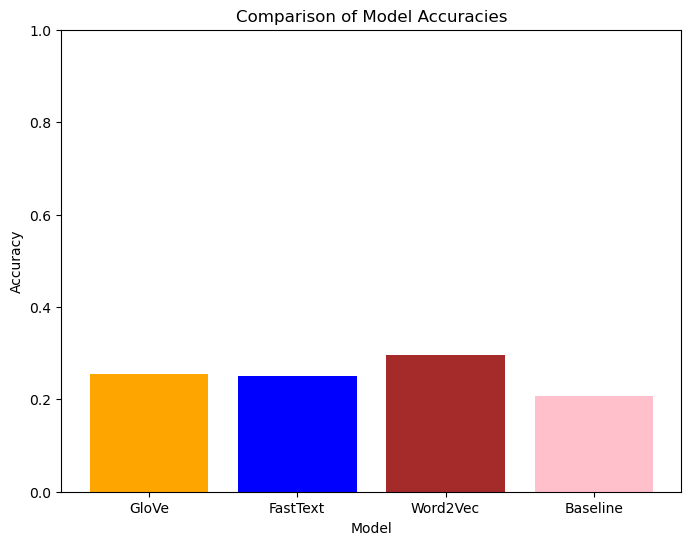

In [182]:
the_accuracy_score_for_models = [accuracy_of_glove , accuracy_of_fastext , accuracy_of_word2vec , accuracy_of_the_baseline_model ]

model_names = ['GloVe', 'FastText', 'Word2Vec', 'Baseline']

plt.figure(figsize=(8, 6))

plt.bar(model_names, the_accuracy_score_for_models, color=['orange', 'blue', 'brown', 'pink'])

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy score

plt.show()


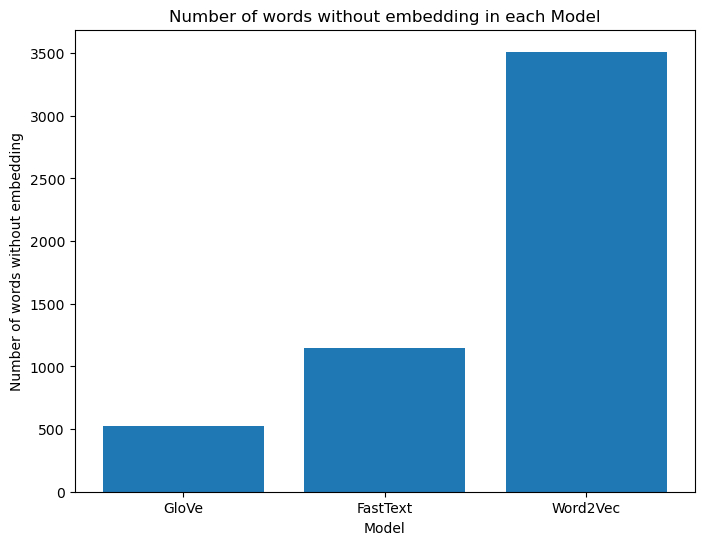

In [217]:
no_of_words_without_embedding_in_each_model = [number_of_words_w1ithout_embedding_using_Glove , number_of_words_w1ithout_embedding_using_fasttext , number_of_words_without_embedding_using_word2vec]
model_names_2 = ['GloVe', 'FastText', 'Word2Vec']
plt.figure(figsize=(8, 6))

plt.bar(model_names_2, no_of_words_without_embedding_in_each_model)

plt.xlabel('Model')
plt.ylabel('Number of words without embedding')
plt.title('Number of words without embedding in each Model')

plt.show()
